In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import sys
import loompy
import scipy.optimize
import os
import seaborn
import bbknn
import re
import importlib
spec = importlib.util.spec_from_file_location("ScanpyUtilsMT", os.path.expanduser("../../utils/ScanpyUtilsMT.py"))
sc_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sc_utils)


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
adata=sc.read('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityPanHumanPresuperviseProcessed.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 956491 × 45421
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'batch_name', 'timepoint', 'region', 'batch', 'clean_cellname', 'full_cellname', 'msregion', 'general_region', 'percent_ribo', 'percent_mito', 'leiden'
    var: 'feature_type-0', 'id-0', 'name-0', 'feature_type-1-0', 'id-1-0', 'name-1-0', 'feature_type-1-1', 'id-1-1', 'name-1-1', 'feature_type-1-10', 'id-1-10', 'name-1-10', 'feature_type-1-100', 'id-1-100', 'name-1-100', 'feature_type-1-101', 'id-1-101', 'name-1-101', 'feature_type-1-102', 'id-1-102', 'name-1-102', 'feature_type-1-103', 'id-1-103', 'name-1-103', 'feature_type-1-104', 'id-1-104', 'name-1-104', 'feature_type-1-105', 'id-1-105', 'name-1-105', 'feature_type-1-106', 'id-1-106', 'name-1-106', 'feature_type-1-107', 'id-1-107', 'name-1-107', 'feature_type-1-108', 'id-1-108', 'name-1-108', 'feature_type-1-109', 'id-1-109', 'name-1-109', 'feature_type-1-11', 'id-1-11', 'name-1-11', 'feature_type-1-110', 'id-

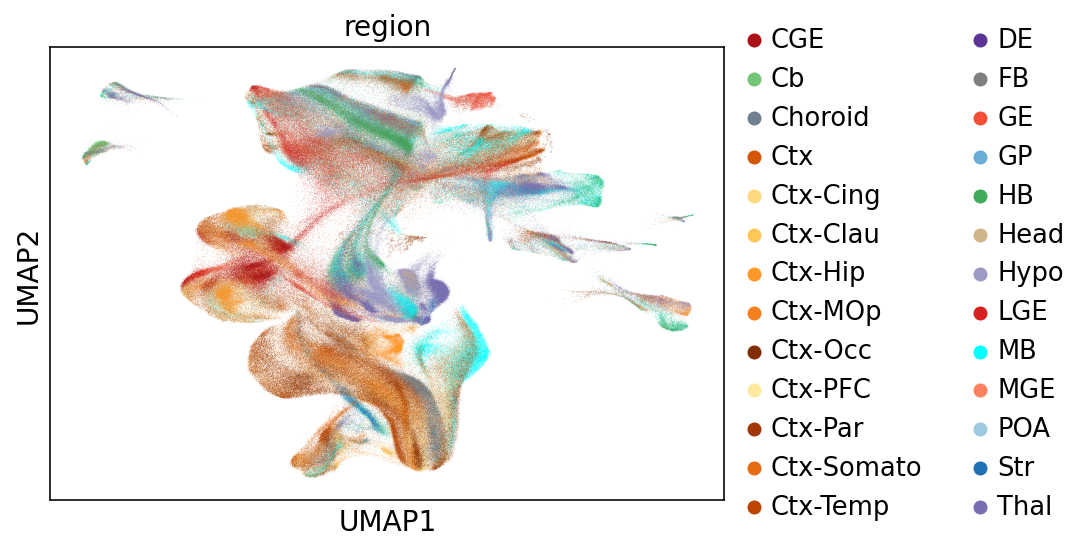

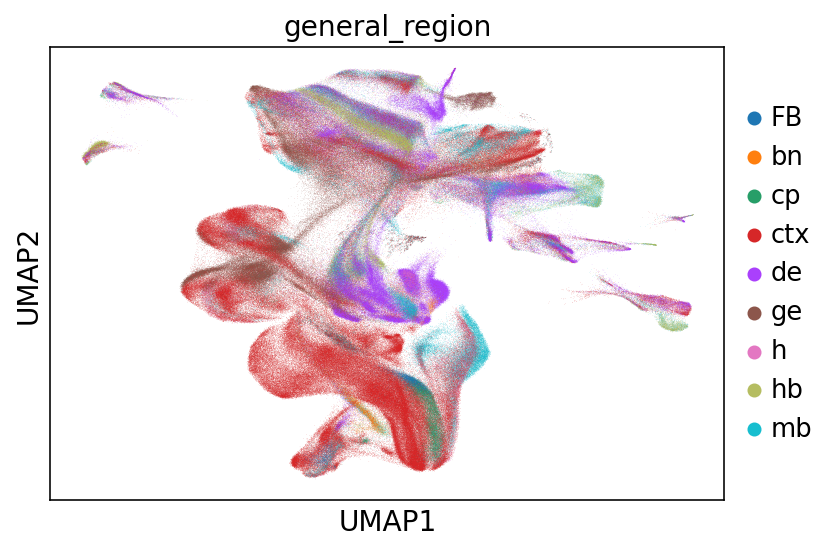

In [4]:
%matplotlib inline
sc.pl.umap(adata,color='region')
sc.pl.umap(adata,color='general_region')

In [5]:
adata=adata[np.random.choice(adata.obs.index,size=100000,replace=False),:]

In [6]:
adata.write('/wynton/scratch/mtschmitz/Human100k.h5ad')

In [2]:
genomepath='/wynton/group/ye/mtschmitz/refdata2/hg38/'
t2g=pd.read_csv(os.path.join(genomepath,'cDNA_introns_t2g.txt'),sep='\t',header=None)
t2g.loc[t2g[2].isna(),2]=t2g.loc[t2g[2].isna(),1]
t2gdict=dict(zip(t2g[1],t2g[2]))

In [17]:
%%time
filepath=os.path.expanduser(os.path.join('/wynton/scratch/mtschmitz/fastqpool/humanfastqpool'))
fileList=os.listdir(filepath)
fileList=[x for x in fileList if 'kout' in x.lower()]
print(fileList)
fileList=[x for x in fileList if ('rhomb' in x.lower()) or ('mesence' in x.lower())]
#fileList+=['GW20CGE_kOut']
fileList
print(fileList)

['chromium_SN033_cr_kOut', 'GW16_MotorVZ_0_1_HNJJMDMXX_kOut', 'GW16_V1_0_1_HNJJMDMXX_kOut', 'chromium_SN003_cr_kOut', 'GW16_Temporal_0_1_HNJJMDMXX_kOut', 'GW16_SomatoVZ_0_1_HNJJMDMXX_kOut', 'GW16_ParietalVZ_0_1_HNJJMDMXX_kOut', 'GW16_TemporalVZ_0_1_HNJJMDMXX_kOut', 'chromium_SN009_cr_kOut', 'GW16_PFC_0_1_HNJJMDMXX_kOut', 'chromium_SN022_cr_kOut', 'GW18_01_P_fastqhypothalamus_kOut', 'chromium_SN026_cr_kOut', 'GW16_fastqhippocampus_kOut', 'chromium_SN095_cr_kOut', 'chromium_SN170_cr_kOut', 'GW18_02_lane1_fastqhypothalamus_kOut', 'GW18_02_lane2_fastqhypothalamus_kOut', 'GW18_01_M_fastqhypothalamus_kOut', 'chromium_SN096_cr_kOut', 'chromium_SN021_cr_kOut', 'GW12_01_fastqhypothalamus_kOut', 'chromium_SN105_cr_kOut', 'chromium_SN297_cr_kOut', 'GW12_02_fastqhypothalamus_kOut', 'GW18_02_lane3_fastqhypothalamus_kOut', 'GW16_motor_0_1_HNJJMDMXX_kOut', 'chromium_SN034_cr_kOut', 'chromium_SN121_cr_kOut', 'chromium_SN030_cr_kOut', 'chromium_SN100_cr_kOut', 'chromium_SN097_cr_kOut', 'GW15_P_fastqhyp

In [39]:
adatas=[]
filename='aem_cellbended_150_750_175e_V0.2'
for f in fileList[1:]:
    print(f,flush=True)
    #try:
    if os.path.exists(os.path.join(filepath,f,filename,'aem_cellbended_filtered.h5')):
        sadata = sc_utils.readCellbenderH5(os.path.join(filepath,f,filename,'aem_cellbended_filtered.h5'))
        sadata =sadata[sadata.obs['latent_cell_probability']>.99,:]
        sc.pp.filter_cells(sadata,min_genes=500)
    else:
        #continue
        print(os.path.join(filepath,f,'all_em'),flush=True)
        sadata=sc_utils.loadPlainKallisto(os.path.join(filepath,f,'all_em'),min_genes=500)
    print(1,flush=True)
    sadata.obs.index=[re.sub("-1","",x) for x in sadata.obs.index]
    sadata.uns['name']=f
    sadata.obs['batch_name']=str(sadata.uns['name'])
    print(2,flush=True)
    print(2.01,flush=True)
    sadata.obs['timepoint']=sc_utils.tp_format_human(sadata.uns['name'])
    print(2.1,flush=True)
    regionstring=sc_utils.region_format_human(sadata.uns['name'])
    print(2.2,flush=True)
    regionstring=regionstring.lower()
    print(3,flush=True)
    sadata.obs['region']=regionstring
    adatas.append(sadata)
    #except:
    #    continue

#hdatas=hdatas+[multi]
hdata=sc.concat(adatas)

GW17_rhombencephalon_kOut
/wynton/scratch/mtschmitz/fastqpool/humanfastqpool/GW17_rhombencephalon_kOut/all_em



KeyboardInterrupt



In [20]:
adatas

[AnnData object with n_obs × n_vars = 6945 × 60722
     obs: 'batch_name', 'timepoint', 'region'
     var: 'gene_ids-0', 'feature_types-0', 'gene_ids-1', 'feature_types-1'
     uns: 'name'
     layers: 'unspliced', 'spliced', 'ambiguous',
 AnnData object with n_obs × n_vars = 7342 × 60722
     obs: 'batch_name', 'timepoint', 'region'
     var: 'gene_ids-0', 'feature_types-0', 'gene_ids-1', 'feature_types-1'
     uns: 'name'
     layers: 'unspliced', 'spliced', 'ambiguous',
 AnnData object with n_obs × n_vars = 356 × 60722
     obs: 'batch_name', 'timepoint', 'region'
     var: 'gene_ids-0', 'feature_types-0', 'gene_ids-1', 'feature_types-1'
     uns: 'name'
     layers: 'unspliced', 'spliced', 'ambiguous',
 AnnData object with n_obs × n_vars = 4876 × 60722
     obs: 'batch_name', 'timepoint', 'region'
     var: 'gene_ids-0', 'feature_types-0', 'gene_ids-1', 'feature_types-1'
     uns: 'name'
     layers: 'unspliced', 'spliced', 'ambiguous',
 AnnData object with n_obs × n_vars = 5125 × 

In [21]:
sc.pp.filter_genes(hdata,min_cells=30)
sc.pp.filter_cells(hdata,min_genes=400)


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [22]:
hdata

AnnData object with n_obs × n_vars = 24644 × 23774
    obs: 'batch_name', 'timepoint', 'region', 'n_genes'
    var: 'n_cells'
    layers: 'unspliced', 'spliced', 'ambiguous'

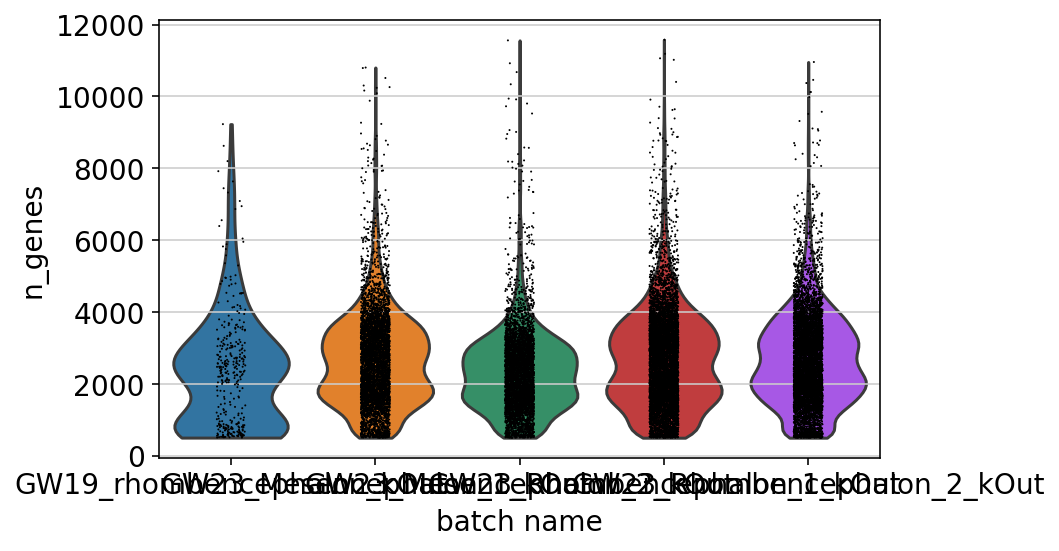

In [25]:
%matplotlib inline
sc.pl.violin(hdata,groupby='batch_name',keys='n_genes')

In [24]:
sc.pl.violin(hdata,groupby='batch_name',keys='n_genes')

In [26]:
sc.pp.normalize_per_cell(hdata)
sc.pp.log1p(hdata)
sc.pp.highly_variable_genes(hdata,n_top_genes=8000)
sc.pp.scale(hdata,max_value=10)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


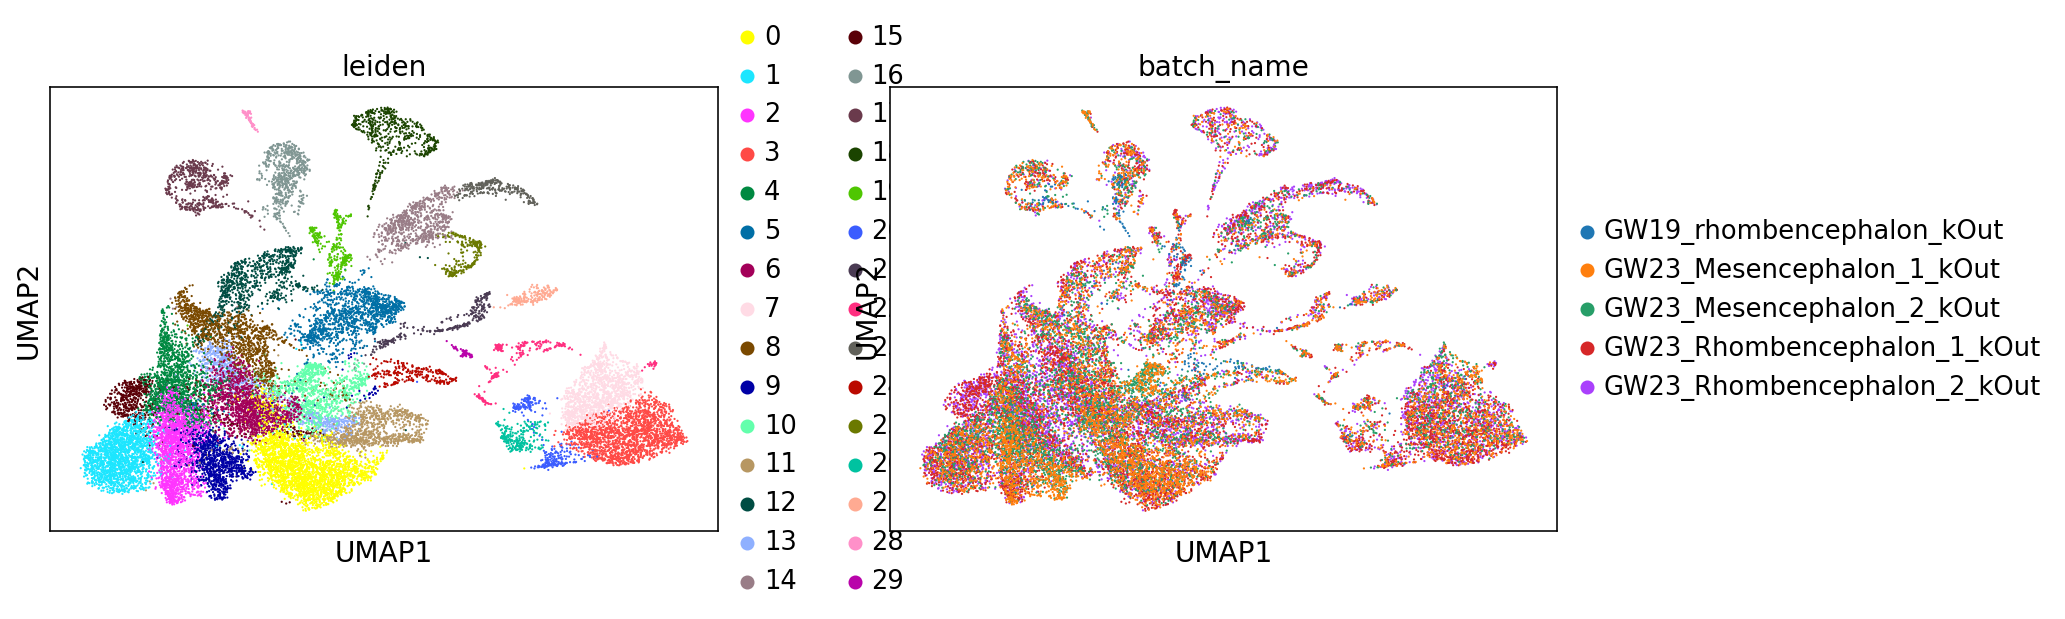

In [27]:
%matplotlib inline
sc.pp.pca(hdata,n_comps=100)
#sc.pp.neighbors(bendedadata)
bbknn.bbknn(hdata,batch_key='batch_name')
sc.tl.leiden(hdata)
sc.tl.umap(hdata)
sc.pl.umap(hdata,color=['leiden','batch_name'])

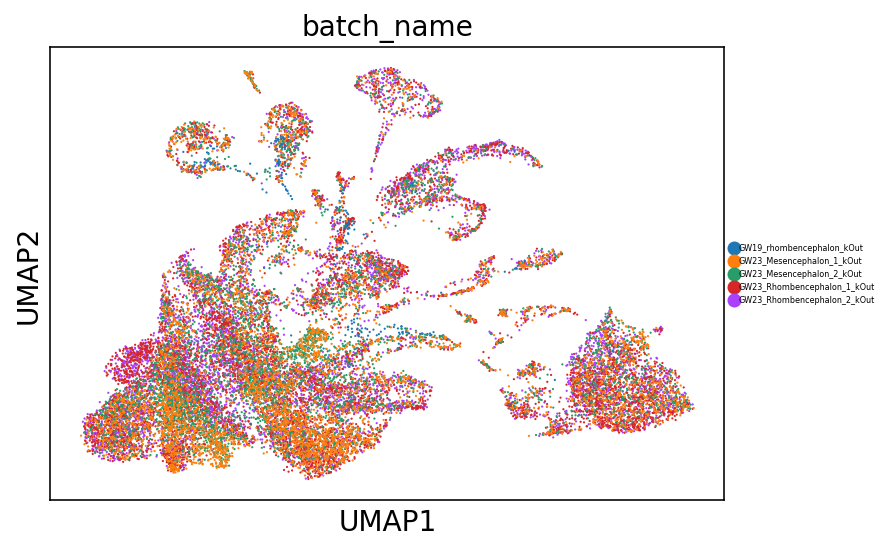

In [31]:
sc.pl.umap(hdata,color=['batch_name'],legend_fontsize=4)

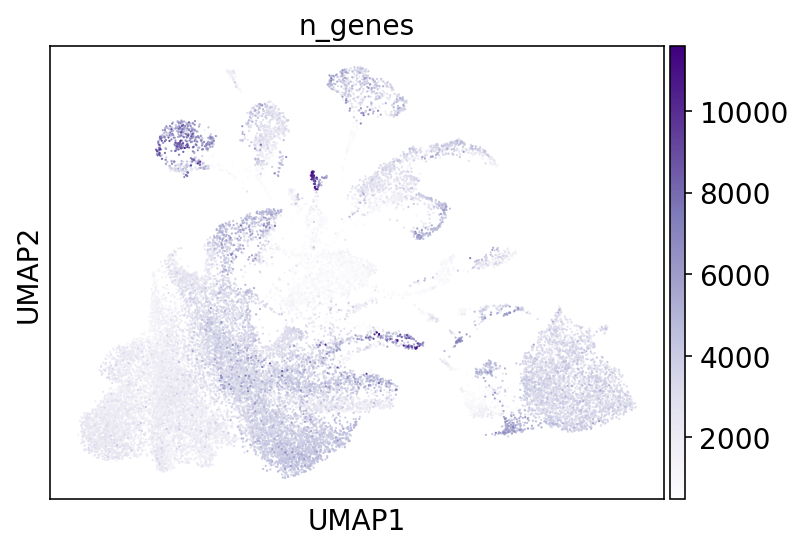

In [41]:
sc.pl.umap(hdata,color=['n_genes'],legend_fontsize=4)

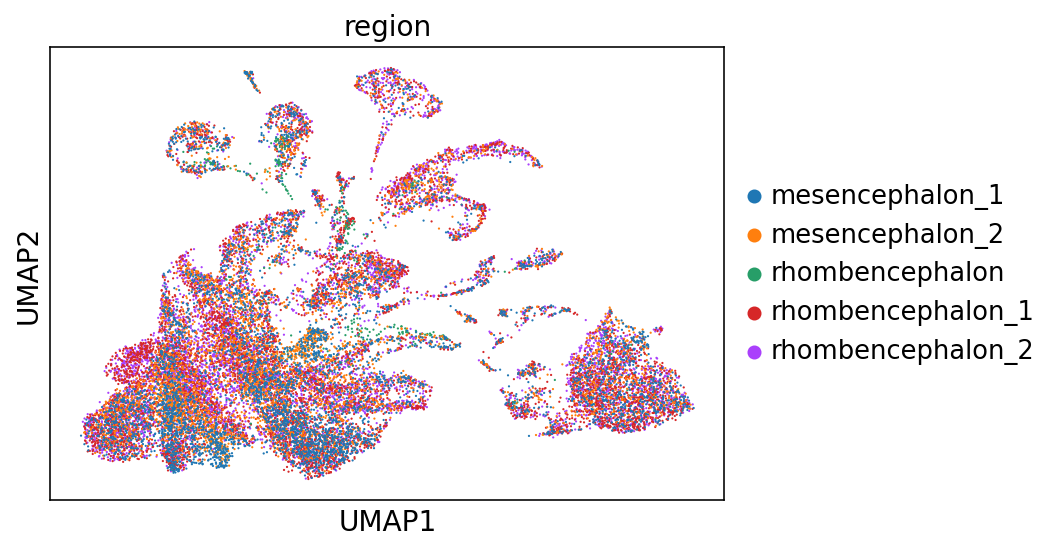

In [29]:
%matplotlib inline
sc.pl.umap(hdata,color=['region'])

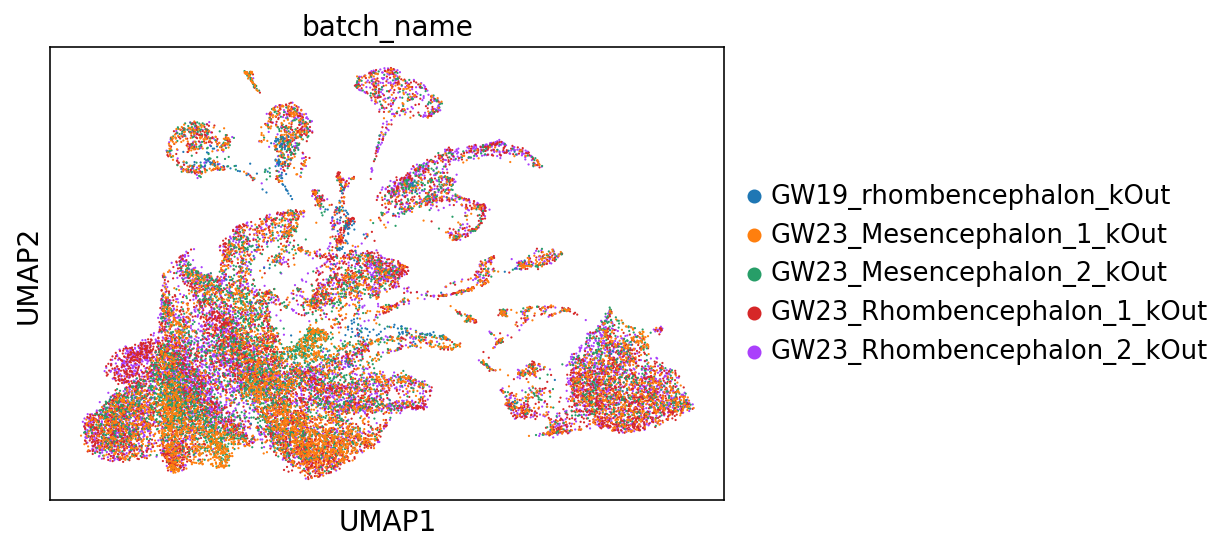

In [30]:
sc.pl.umap(hdata,color=['batch_name'])

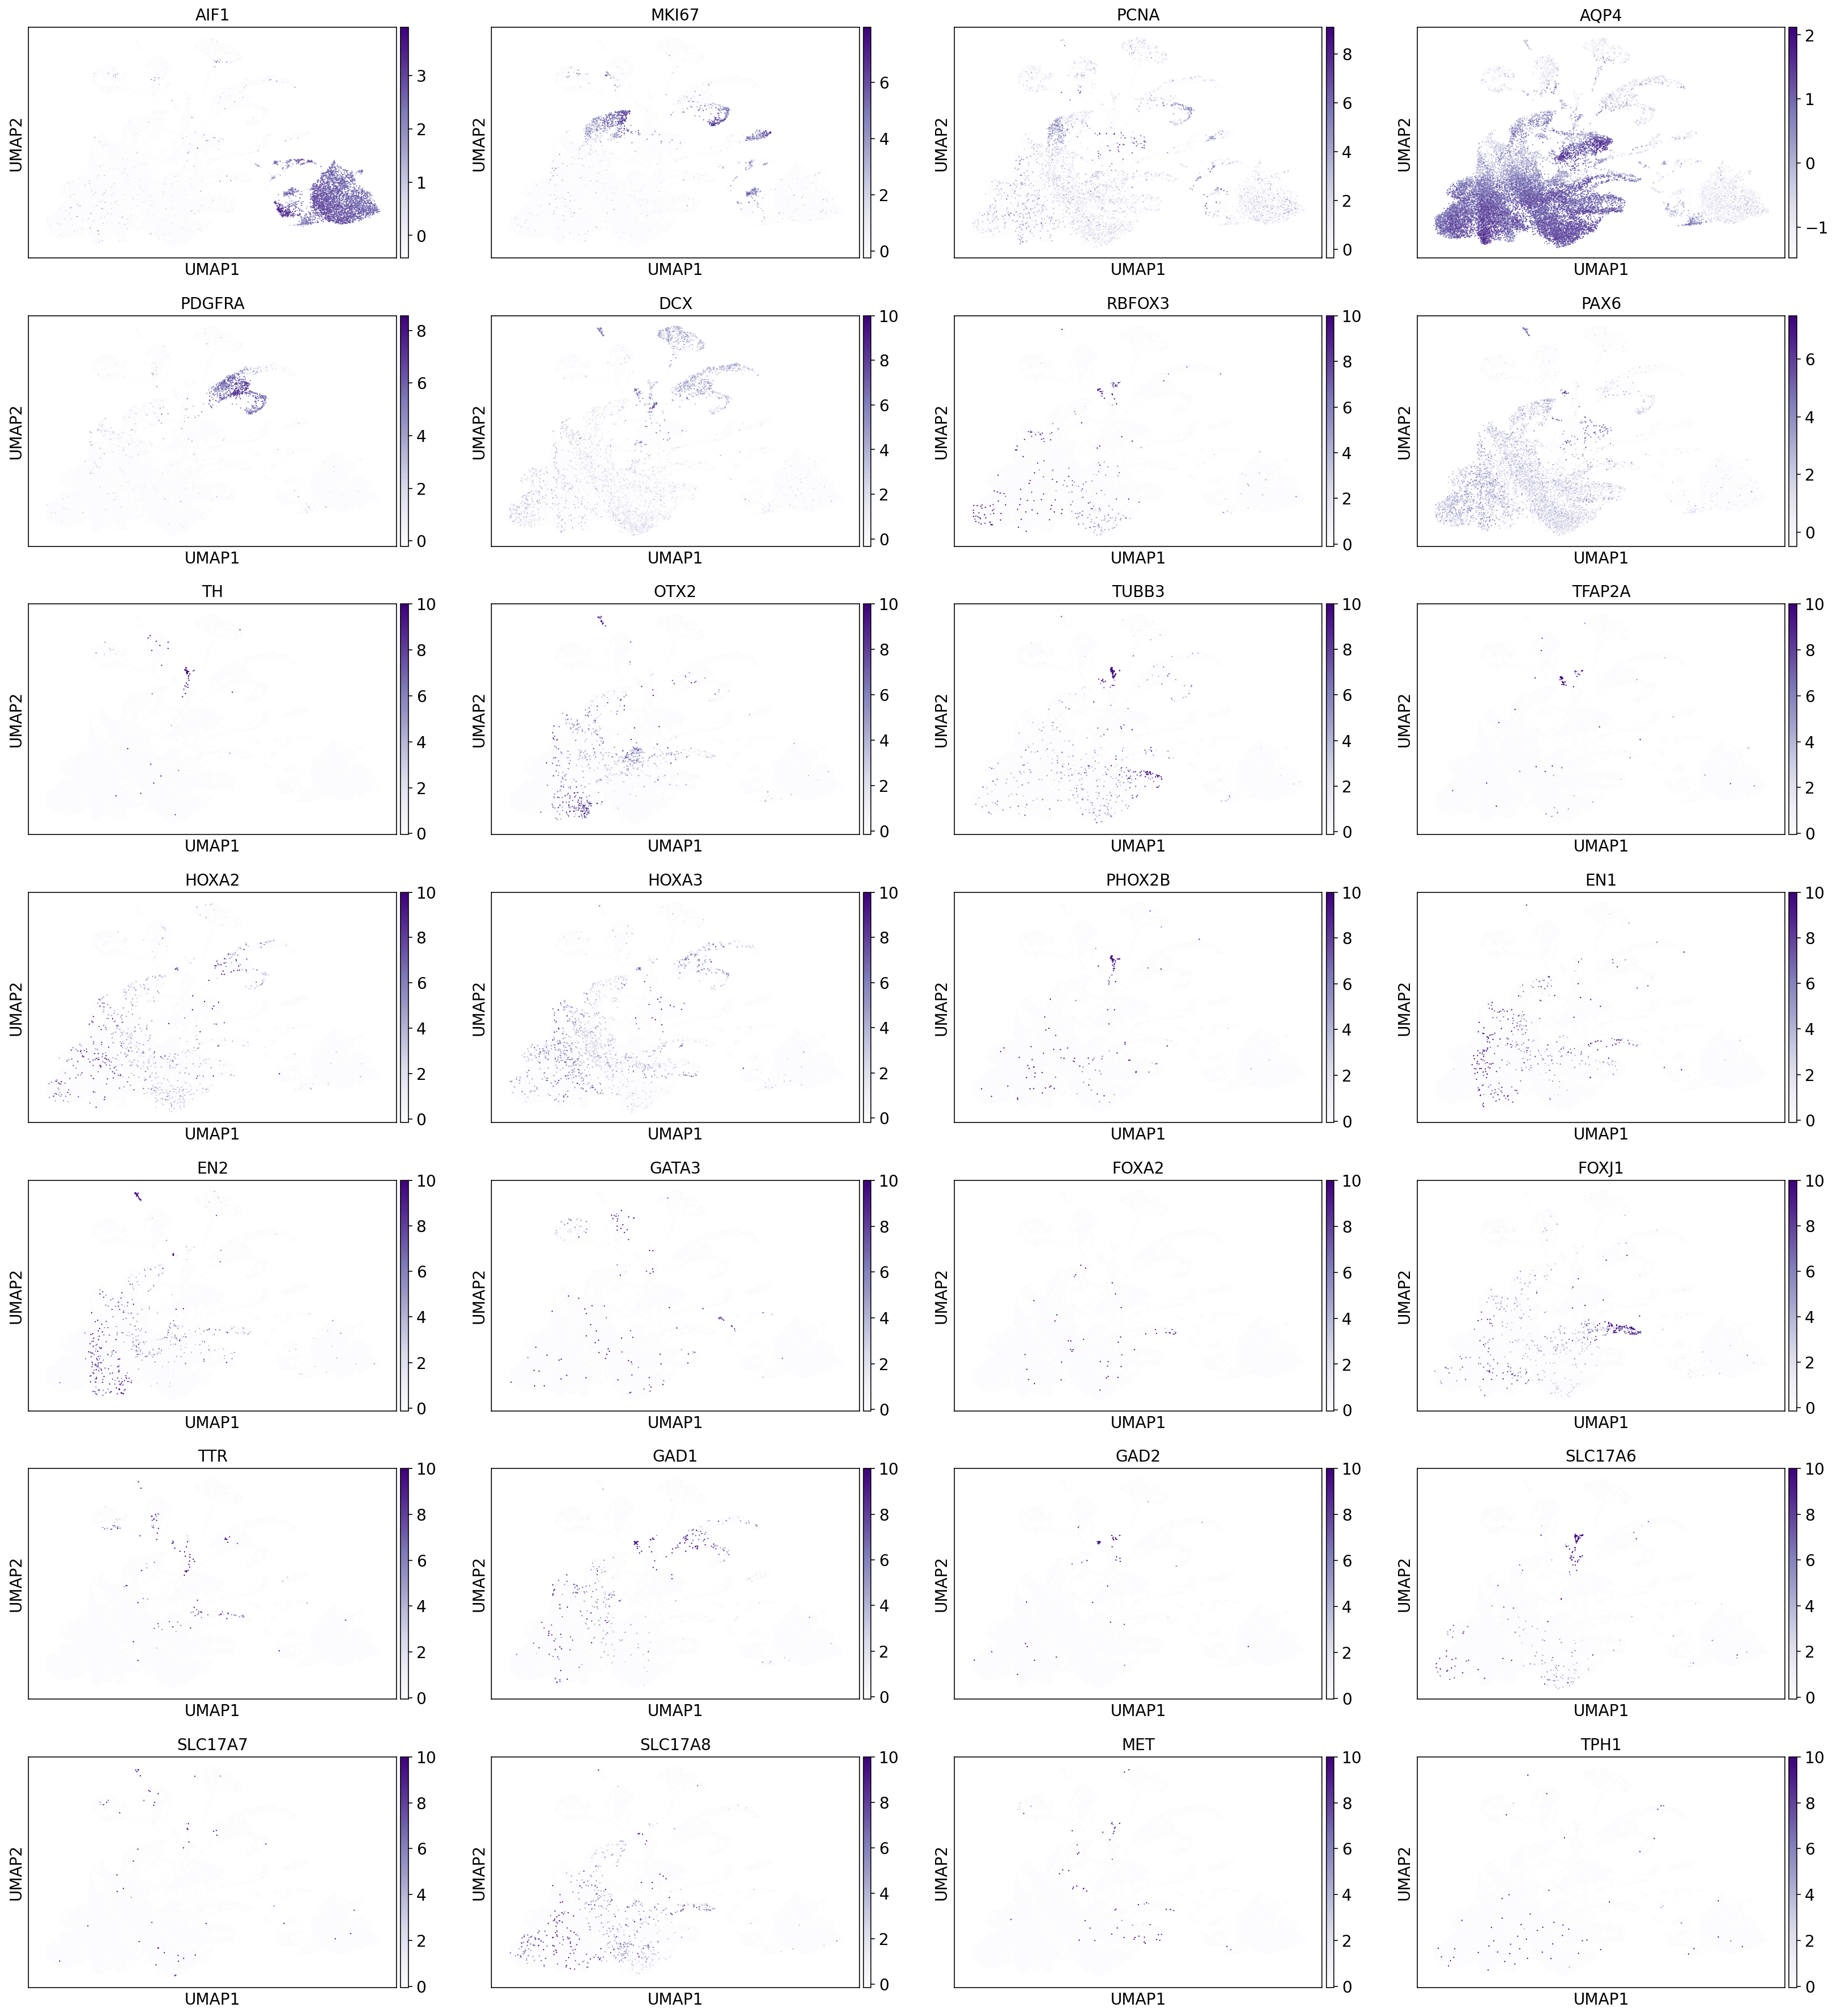

In [42]:
easygenes= ['AIF1','MKI67','PCNA','AQP4','PDGFRA','DCX','RBFOX3','PAX6','TH','OTX2','TUBB3','TFAP2A','HOXA2','HOXA3','MNX1','PHOX2B','EN1','EN2','ISL1','GATA3','FOXA2','FOXJ1','TTR','GAD1','GAD2','SLC17A6','SLC17A7','SLC17A8','MET','TPH1','TPH2']
easygenes=[x for x in easygenes if x in hdata.var.index]
sc.pl.umap(hdata,color=easygenes,use_raw=False)

/wynton/home/ye/mschmitz1/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/wynton/home/ye/mschmitz1/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/wynton/home/ye/mschmitz1/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

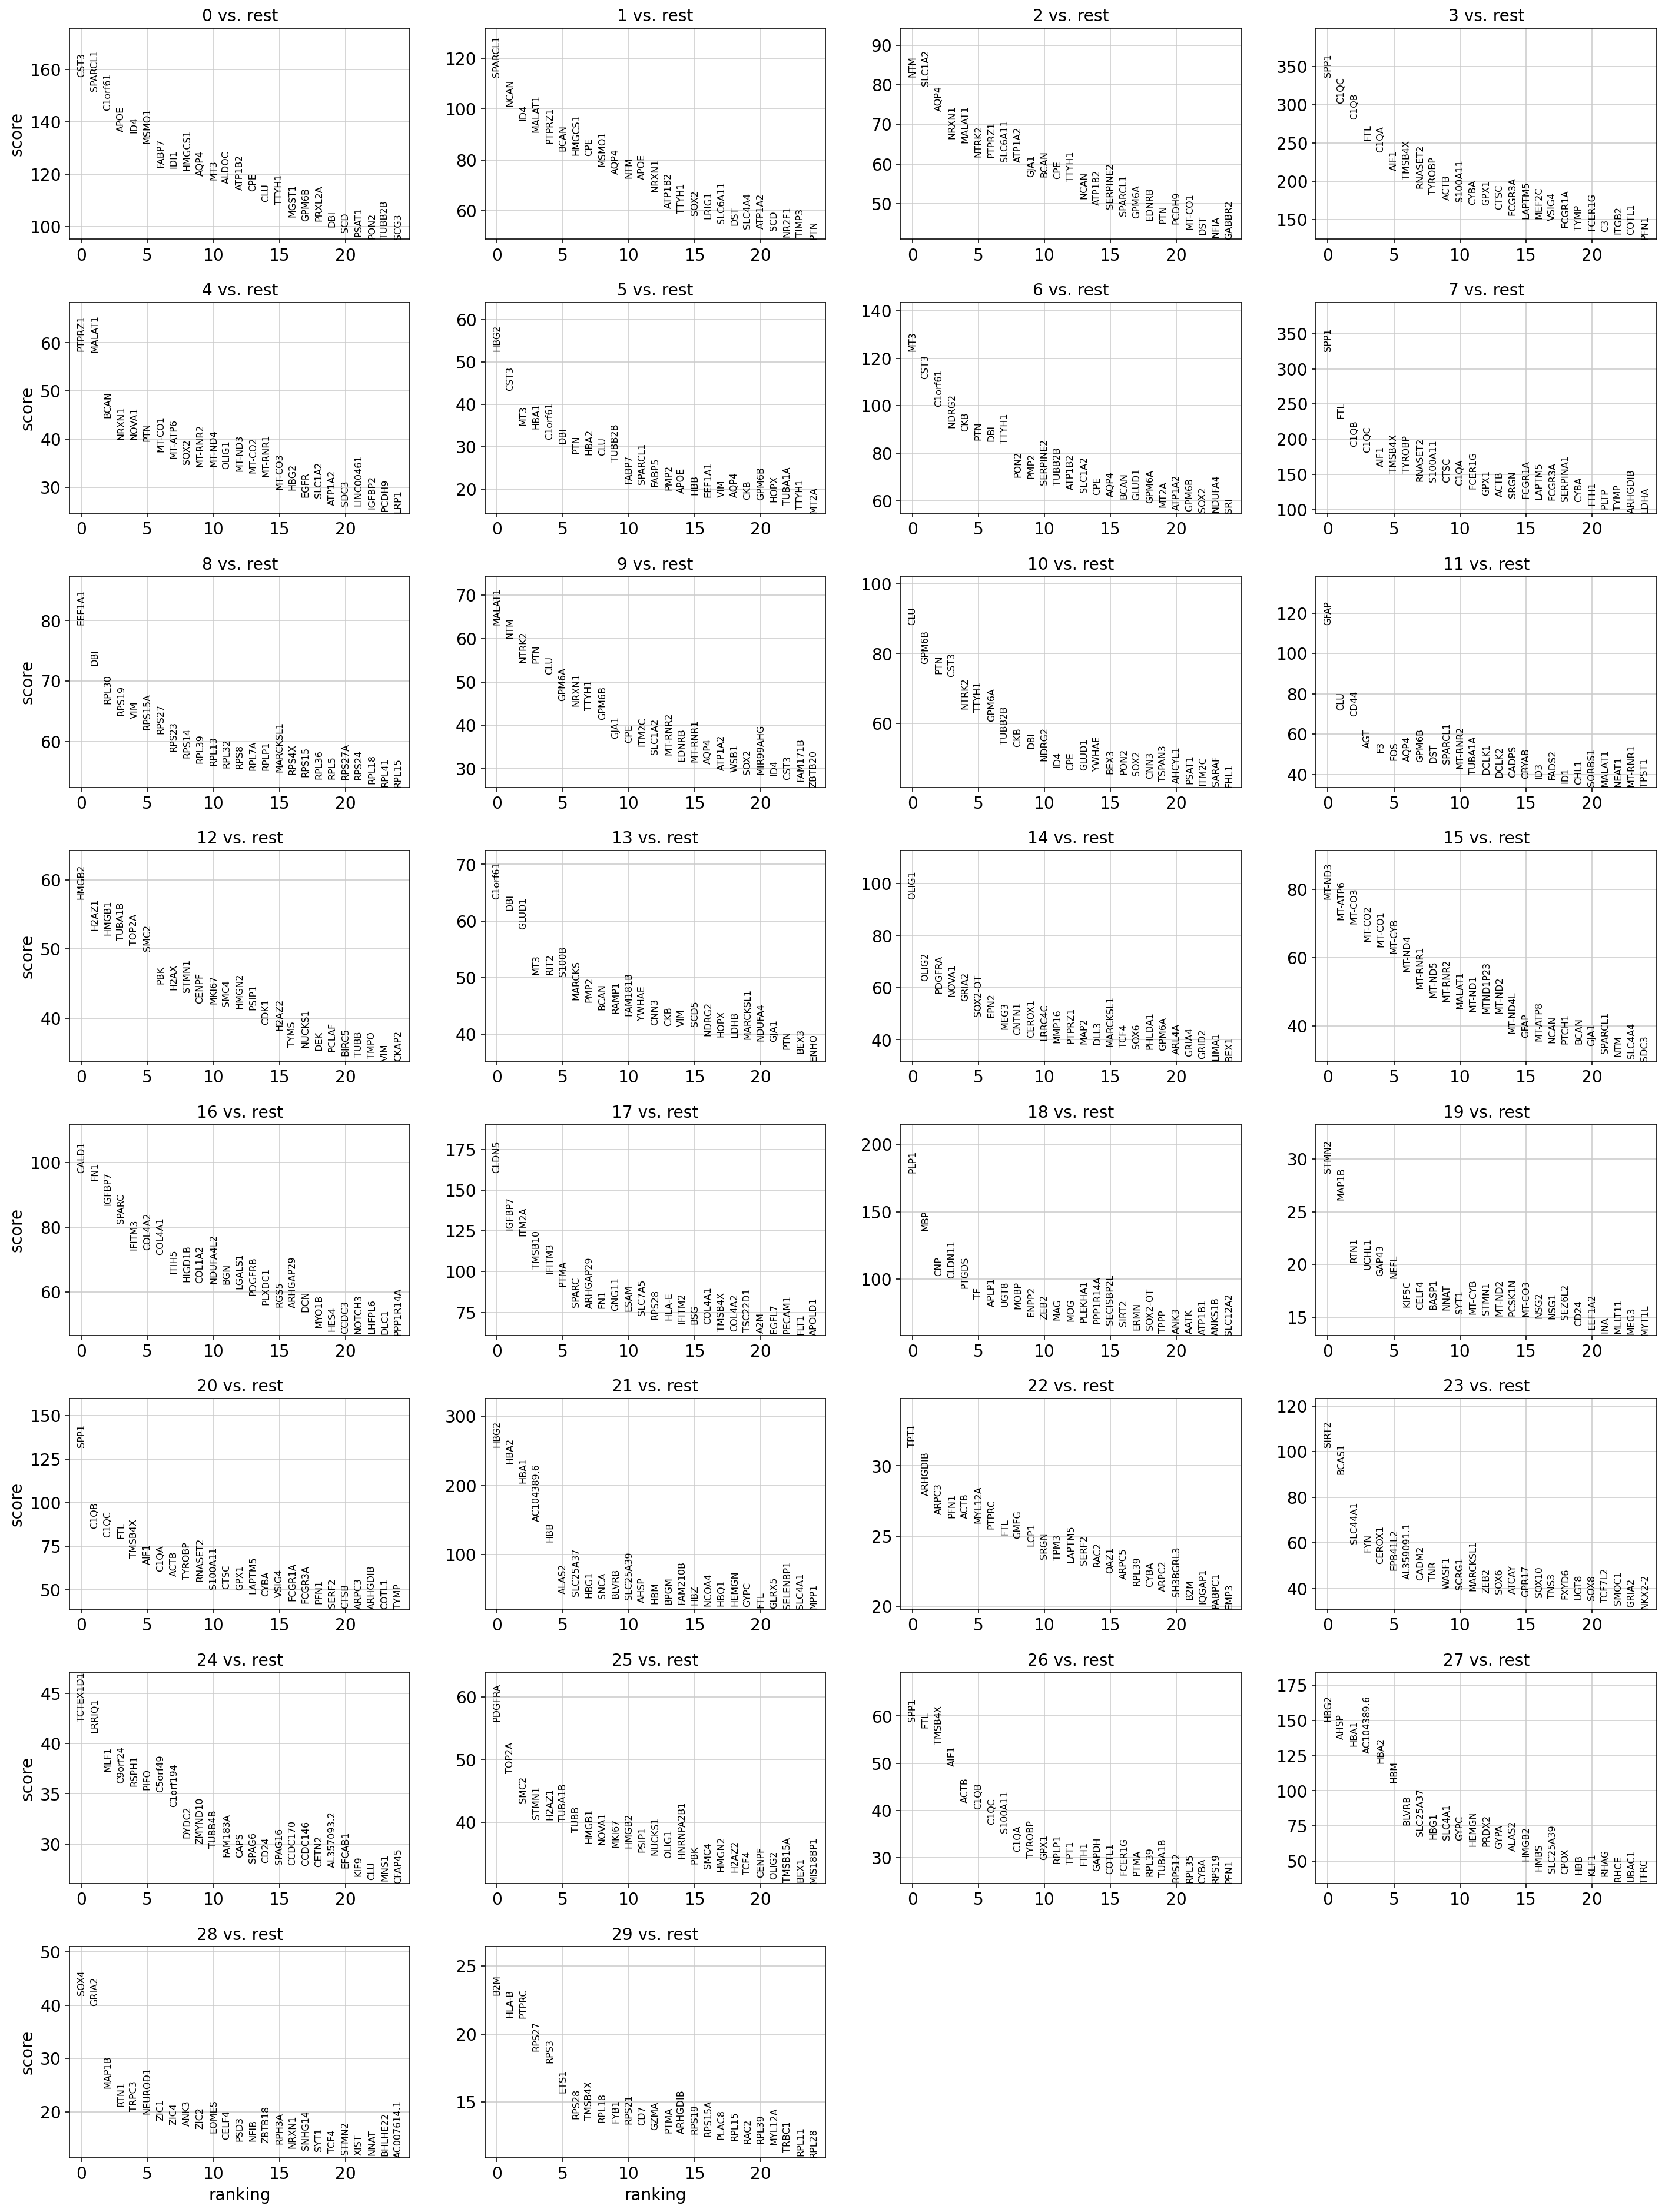

In [40]:
sc.tl.rank_genes_groups(hdata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(hdata, n_genes=25, sharey=False)